# Find the form of an expression by limiting a theoretical expression

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

In [34]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [1]:
from sympy import *

In [4]:
rp,m,rp,r0 = symbols('r,m,r_+,r_0',real=True)

In [3]:
J = Integral()

r

In [9]:
import sympy as sp

# 변수 정의
rp = sp.Symbol('r_+', positive=True,real=True)
Omega = sp.Symbol('Omega')
K, m = sp.symbols('K m', positive=True,real=True)
omega_p = sp.Symbol('omega_+', real=True)
Omegap, dOmega = sp.symbols('Omega_+ \delta\Omega', real=True)

# 함수 정의
g = sp.Function('g')(Omega)

# 첫 번째 적분
lower1 = omega_p
upper1 = omega_p + Omegap + dOmega
integrand1 = g * sp.sqrt(1 - ((Omega - dOmega - omega_p)**2) / (K**2 * rp**2))
I1 = sp.integrate(integrand1, (Omega, lower1, upper1))

# 두 번째 적분
lower2 = omega_p + Omegap + dOmega
upper2 = sp.oo
integrand2 = g * 1 / (2 * (1 + m**2 * Omega**2))
I2 = sp.integrate(integrand2, (Omega, lower2, upper2))

# 전체 식
expr = I1 - K * rp * m * I2

# 극한 계산: r -> 0+
lim_expr = sp.limit(expr, rp, 0, dir='+')
lim_expr


Limit(-K*m*r_+*Integral(g(Omega)/(Omega**2*m**2 + 1), (Omega, Omega_+ + \delta\Omega + omega_+, oo))/2 + Integral(sqrt(K**2*r_+**2 - Omega**2 + 2*Omega*\delta\Omega + 2*Omega*omega_+ - \delta\Omega**2 - 2*\delta\Omega*omega_+ - omega_+**2)*g(Omega), (Omega, omega_+, Omega_+ + \delta\Omega + omega_+))/(K*r_+), r_+, 0)

In [39]:
import numpy as np
from scipy.integrate import quad
from math import sqrt, pi, exp

# Given parameters
K = 6
m = 6
r0 = 0.76

# Very small r_plus approaching 0+
r_plus = 1e-5

# Define omega_c (Domega)
omega_c = 4 * sqrt(K * r_plus) / (pi * sqrt(m) - 0.3056 / sqrt(K * r_plus * m**3))

# Omega_p (same form as omega_c)
Omega_p = omega_c

# Define delta_Omega
numerator = K * (2 * m * r0 + r_plus) * (pi * sqrt(K) * m**2 * sqrt(r_plus) - 0.3056)**3
denominator = 16 * m**(3/2) * (64 * K**2 * m**5 * r_plus**2 + (pi * sqrt(K) * m**2 * sqrt(r_plus) - 0.3056)**2)
delta_Omega = numerator / denominator

# g(Ω) = standard normal PDF
def g(Omega):
    return (1 / sqrt(2 * pi)) * np.exp(-Omega**2 / 2)

# I1 approximation
g_val = g(delta_Omega + omega_c)
I1_approx = g_val * K * r_plus * pi / 2

# I2 integral (numerically)
def integrand(Omega):
    return g(Omega) / (2 * (1 + m**2 * Omega**2))

lower_limit = omega_c + Omega_p + delta_Omega
I2_val, _ = quad(integrand, lower_limit, np.inf)

# Full expression value (divided by r_plus)
limit_val = (I1_approx - K * r_plus * m * I2_val) / r_plus
limit_val


2.922139780661662

In [29]:
r =  0.5
m = 10
omega_p =  4*np.sqrt(K*r/m) - 0.3506 / np.sqrt(K*r*m**3)
Kc2 = 2/np.pi / g(omega_p)

In [30]:
Kc2

17.345833173559125

In [49]:
K = 4
m = 6
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


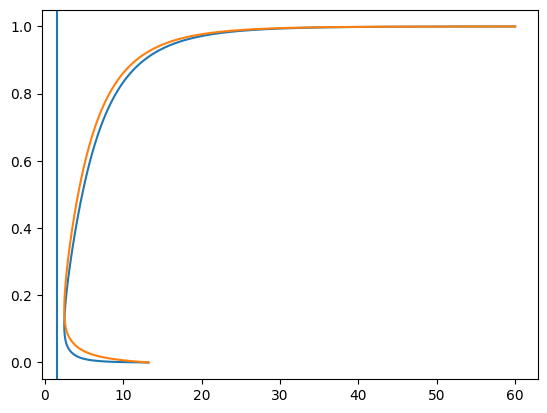

In [58]:
plt.plot(KK,R)
plt.plot(KK,R0)
plt.axvline(2/(np.pi*g(0)))

In [67]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []
Kc2s = np.nan*np.ones_like(K_u)
K1p = []
for i,(X,K,r,r0,rd,OP) in enumerate(list(zip(Xsu,K_u,R_u,R_0u,R_du,OPS))):
    omega_p =  4*np.sqrt(K*r/m) - 0.3056 / np.sqrt(K*r*m**3)
    Kc2s[i] = 2/(np.pi * g(omega_p))

(0.0, 6.0)

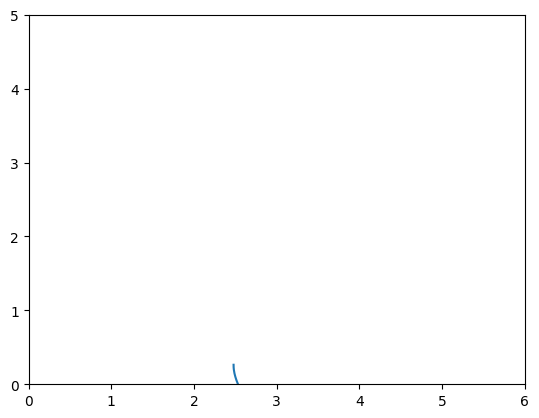

In [65]:
plt.plot(K_u,Kc2s)
plt.ylim(0,5)
plt.xlim(0,6)

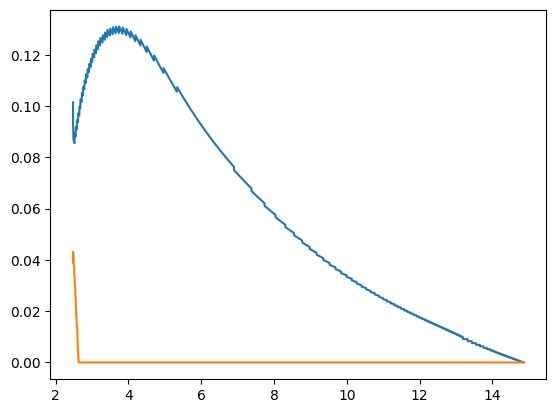

In [69]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    rs1 = np.logspace(-6,np.log10(0.01),100)
    rps = np.r_[rs1,np.linspace(0.01,(1-r0)/2,100)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    # plt.plot(rps,RP-rps)
    
    
    try:
        RP1_u.append(rps[x[-1]])
        RP1_d.append(rps[x[0]])
        RP01_u.append(RP_ls[x[-1]])
        RP01_d.append(RP_ls[x[0]])
        K1p.append(K)
    except:pass
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

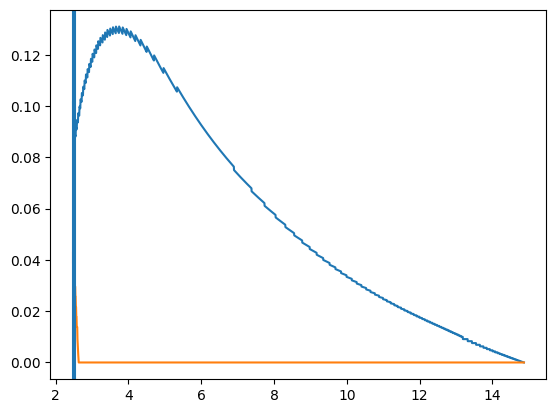

In [70]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.axvline(K_u[np.where(Kc2s<=K_u)][0])
plt.axvline(K_u[np.where(Kc2s<=K_u)][-1])

(0.0, 10.0)

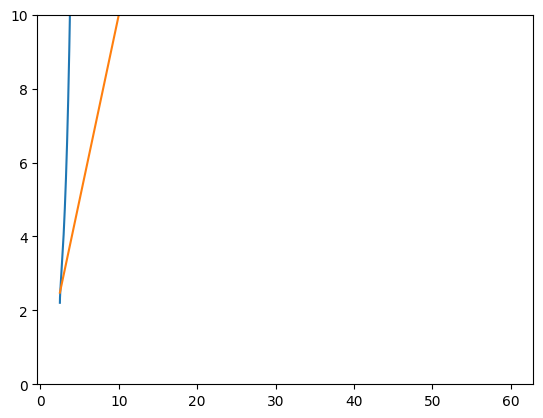

In [53]:
plt.plot(K_u, Kc2s)
plt.plot(K_u, K_u)
plt.ylim(0,10)